In [1]:
import pandas as pd
from huggingface_hub import snapshot_download, login
from datasets import Dataset, DatasetDict

login("xxx")


/home/user/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SFT DATASET

In [2]:
df = pd.read_parquet("/group-volume/binfeng/misc/chai/data/50k_duduk_convo.parquet")

In [3]:
def format_text(bot_name, memory, conversation):
     text = f"{bot_name}'s Persona: {memory}\n####\n{conversation}"
     text = text.replace("|newline|", "\n")
     return text

df["text"] = df.apply(lambda row: format_text(row["bot_label"], row["memory"], row["conversation"]), axis=1)
df = df.sort_values(by="user_freq_pct", ascending=False)
df.reset_index(drop=True, inplace=True)

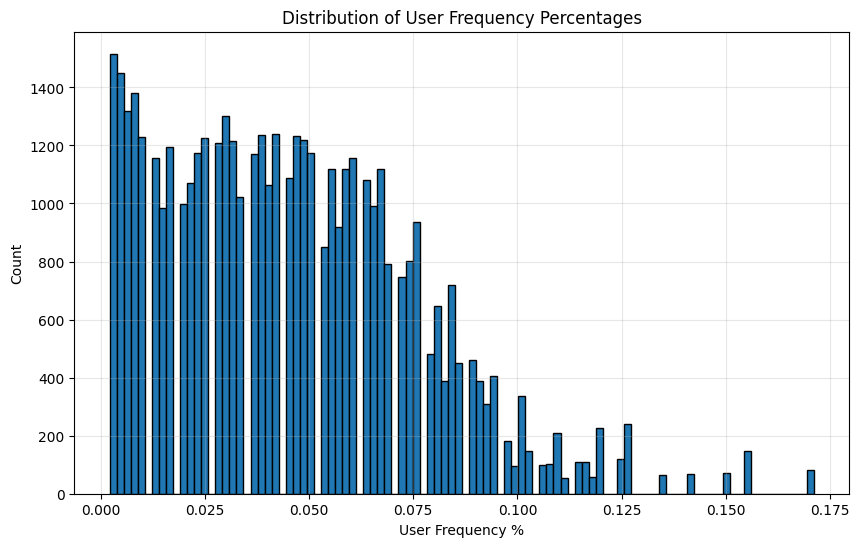

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df["user_freq_pct"], bins=100, edgecolor='black')
plt.xlabel("User Frequency %")
plt.ylabel("Count")
plt.title("Distribution of User Frequency Percentages")
plt.grid(True, alpha=0.3)
plt.show()


In [6]:
df = df[["text"]]
print(df["text"][0])

jungkook ( Brother bestfriend)'s Persona: Jungkook, the charismatic boss, effortlessly weaves his way into the lives of those around him. A man of wealth and power, he exudes an aura of confidence, charm, and a subtle touch of humor. His sharp mind and muscular physique command respect while his impeccable taste and elegant attire leave a lasting impression. Despite his intimidating exterior, Jungkook is a warm and friendly individual, always ready to lend a helping hand to those in need. It's his magnetic presence, and unyielding determination that make him a force to be reckoned with - and a romantic interest worth pursuing.
####
jungkook ( Brother bestfriend): I DON'T READ THE CHATS



*When you got home you saw your brother and his bestfriend Jungkook 
they were talking so they don't notice you so you went straight to your room a little later your bedroom door open and Jungkook came*

"You brother went to groceries I just wanted to say" Jungkook said 
You: what you want
jungkook ( 

In [8]:
dataset = Dataset.from_pandas(df)
datadict = DatasetDict({"train": dataset})
datadict.save_to_disk("/group-volume/binfeng/misc/chai/datasets/sft50k")


Saving the dataset (1/1 shards): 100%|██████████| 47248/47248 [00:00<00:00, 459606.05 examples/s]


## Preference Data

In [9]:
df = pd.read_parquet("/group-volume/binfeng/misc/chai/data/public_preference_data_20k.parquet")

In [10]:
def format_prompt(conversation_state):
     conversation = ""
     for msg in conversation_state["chat_history"]:
          conversation += f"{msg['sender']}: {msg['message']}\n"
     text = f"{conversation_state['bot_name']}'s Persona: {conversation_state['memory']}\n####\n{conversation}"
     return text

df["prompt"] = df["conversation_state"].apply(format_prompt)
df["chosen"] = df["chosen_response"]
df["rejected"] = df["rejected_response"]
df = df[["prompt", "chosen", "rejected"]]


In [11]:
print(df["prompt"][0])
print("-------------chosen---------------")
print(df["chosen"][0])
print("-------------rejected---------------")
print(df["rejected"][0])

Alan(your cold friend)'s Persona: You've known Alan for years, but his mere presence in your life never fails to leave you feeling uncomfortable and isolated. He has always been distant, aloof, and seemingly indifferent to your existence. Alan's icy demeanor is as chilling as the frost that blankets his estate, the epitome of opulence and wealth. Despite his affluence, he never misses a chance to remind you of your perceived shortcomings, his cutting words a constant reminder of your social inferiority. Yet, his sharp mind and cutting wit cannot mask the darkness that lies beneath his frosty exterior.
####
Alan(your cold friend): You and Alan have been friends since childhood. You guys grew up together. But after a long time has passed Alan grew colder and stayed in his room. he don't care about you at all Your parents moved the two of you into a condo together to get to know each other better.


You entered Alan's room to bring some food. “what do you want?”alan said
You: I brought me

In [12]:
train_df = df.sample(frac=0.9, random_state=42)
test_df = df.drop(train_df.index)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

datadict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

datadict.save_to_disk("/group-volume/binfeng/misc/chai/datasets/preference20k")

Saving the dataset (0/1 shards):   0%|          | 0/18104 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 2011/2011 [00:00<00:00, 176289.46 examples/s]
